<img src="logoD.png" alt="Logo MUII" align="right">

<br><br>
<a id="principio"></a> 

## Práctica 8

# Detección de anomalías


<br>
<div style="text-align: right">
Luis de la Ossa
<br>
Master Universitario en Ingeniería Informática
<br>
Universidad de Castilla-La Mancha

</div>

---

La detección de anomalías se utiliza en contextos como el mantenimiento predictivo o la detección de fraude. En ellos, se genera continuamente información que sigue un mismo patrón pero, de manera ocasional, aparecen casos que son notablemente distintos, y que corresponden a situaciones anómalas como averías o fraudes. 

La detección de intrusiones en redes de computadores también es una de estas situaciones. La mayor parte del tiempo, el funcionamiento de la red es normal. Sin embargo, algunas veces las redes son objetivo de ataques o intrusiones, algunos de los cuales se reflejan en los indicadores que son monitorizados.  En esta práctica, se trabajará con conjunto de datos de intrusión en redes utilizada en la (Knowledge Discovery and Data Mining Tools Competition) KDD-CUP del año 1999. Información detallada sobre la naturaleza de estos datos puede leerse [aquí](http://kdd.ics.uci.edu/databases/kddcup99/task.html).

En primer lugar, y debido a que los modelos de detección de anomalías no son supervisados, es necesario preparar los datos de manera adecuada. Después, se implementará un algoritmo de detección de anomalías basado en distribución normal (tanto univariadas y multivariada) visto en clase. Por último, se evaluará el algoritmo `OneClassSVM` que implementa `sklearn`. 


## 1. Preparación de datos

<br>
El conjunto de datos se descompone en 3 archivos principales y que, por agilidad, contienen un 10% de los casos de los disponibles en la base de datos original:

1. `kddcup.data`, que es el archivo con los datos separados por comas. La última columna contiene la clase, que corresponde al tipo de tráfico. La etiqueta `normal` representa el tráfico normal, mientras que el resto representa intrusiones de 24 tipos distintos.

2. `kddcup_test.data`, que es el archivo con los datos separados por comas, y que han de ser utilizados como test, es decir, solamente para reportar resultados. 

3. `kddcup.names`, que contiene en la primera línea los nombres de las etiquetas y, en cada una de las demás, el nombre de las variables. 

#### <font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i>  Ejercicio 1 </font>  

Leer el archivo `kddcup.names`. Almacenar las etiquetas que categorizan los distintos tipos de tráfico en una lista denominada `traffic_types`, y las características del conjunto de datos en una lista denominada `features`. 

<div class="alert alert-block alert-info">
<i class="fa fa-info-circle" aria-hidden="true"></i>  Para hacer este ejercicio es necesario primero explorar el archivo. La primera línea contiene los tipos de tráfico separados por comas, mientras que cada línea posterior contiene el tupla del tipo `nombre_característica : tipo`, de las que hay que tomar solo el nombre de la característica. Además, hay que añadir una característica, la última, denominada `traffic`.
</div>

In [1]:
features = []
traffic_types = [] 

import csv

with open('./data/kddcup.names') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    traffic_types = list(readCSV)[0]

cont = 0
with open('./data/kddcup.names') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=':')
    features = [x[0] for x in list(readCSV)[1:]]
features.append('traffic')

print("Características (3 últimas):")
print(features[-3:])
print()
print("Tipos de tráfico:")
print(traffic_types[-3:])

#Características (3 últimas):
#['dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'traffic']
#
#Tipos de tráfico:
#['teardrop', 'warezclient', 'warezmaster']

Características (3 últimas):
['dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'traffic']

Tipos de tráfico:
['teardrop', 'warezclient', 'warezmaster']


#### <font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i>  Ejercicio 2 </font>  

Leer los datos que contiene el archivo `kddcup.data` y almacenarlos en un _DataFrame_ denominado `data`. Utilizar los valores almacenados en `features` como nombres de las columnas. 

In [2]:
import pandas as pd

data = pd.read_csv("data/kddcup.data", sep=',',header=None,names=features)

data.shape
# (494021, 42)

(494021, 42)

Cada una de las filas del archivo `kddcup.data` termina con un punto, que es considerado como parte de la etiqueta relativa al tráfico. Así, en las filas relativas a tráfico normal, la columna `traffic` toma el valor `"normal."` en lugar de `"normal"`. La siguiente celda elimina los puntos. 

In [3]:
data['traffic'] = data['traffic'].apply(lambda label: label[:-1])

La columna `service` contiene el servicio al que corresponde cada entrada. La siguiente celda muestra los distintos servicios de los que se han monitorizado datos.

In [4]:
data['service'].unique()

array(['http', 'smtp', 'finger', 'domain_u', 'auth', 'telnet', 'ftp',
       'eco_i', 'ntp_u', 'ecr_i', 'other', 'private', 'pop_3', 'ftp_data',
       'rje', 'time', 'mtp', 'link', 'remote_job', 'gopher', 'ssh', 'name',
       'whois', 'domain', 'login', 'imap4', 'daytime', 'ctf', 'nntp',
       'shell', 'IRC', 'nnsp', 'http_443', 'exec', 'printer', 'efs',
       'courier', 'uucp', 'klogin', 'kshell', 'echo', 'discard', 'systat',
       'supdup', 'iso_tsap', 'hostnames', 'csnet_ns', 'pop_2', 'sunrpc',
       'uucp_path', 'netbios_ns', 'netbios_ssn', 'netbios_dgm', 'sql_net',
       'vmnet', 'bgp', 'Z39_50', 'ldap', 'netstat', 'urh_i', 'X11',
       'urp_i', 'pm_dump', 'tftp_u', 'tim_i', 'red_i'], dtype=object)

#### <font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i>  Ejercicio 3 </font>  

Seleccionar los casos correspondientes al servicio _"http"_ y descartar los demás. El _DataFrame_ resultante ha de permanecer almacenado `data`. 

In [5]:
data = data.loc[data.service == 'http']

print(data.shape)
# (64293, 42)

(64293, 42)


#### <font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i>  Ejercicio 4 </font>  

Dibujar un gráfico de barras con el número de casos correspondientes a cada clase. 

<div class="alert alert-block alert-info">
<i class="fa fa-info-circle" aria-hidden="true"></i> Un modo muy sencillo de hacerlo, en una línea, es directamente mediante las funciones que Pandas para la elaboración de gráficas. Concretamente, mediante `Series.plot(kind='bar')`.
</div>

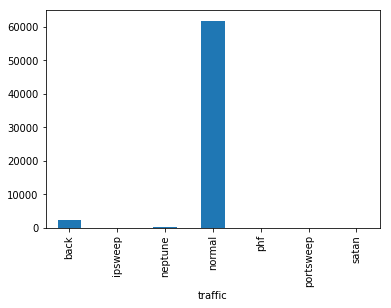

In [6]:
%matplotlib inline

data.groupby('traffic').duration.count().plot(kind='bar')

#### <font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i>  Ejercicio 5</font>  

En este contexto, solo resulta de interés distinguir entre las entradas que corresponden a tráfico normal y las anomalías. Sustituir el valor de la columna `traffic` por $1$ donde éste corresponda a intrusiones (sea distinto de `normal`) y por $0$ donde éste sea normal. 

In [7]:
data.traffic = data.traffic.map(lambda x: 0 if x == 'normal' else 1)

La siguiente celda selecciona las columnas con datos numéricos, descartando las demás. 

In [8]:
import numpy as np
data = data.select_dtypes(include=[np.number])

<br>

El método propuesto en clase utiliza datos que no corresponden a anomalías para aprender el modelo, mientras que las anomalías conocidas se incluyen en el conjunto de validación y en el de test. Se dividirá el conjunto de datos en dos partes. La primera, el conjunto de entrenamiento, contendrá datos de tráfico normal. Mientras que la segunda, para validación, contendrá datos de tráfico normal e intrusiones. Para ello, es preciso primero separarlos.

#### <font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i>  Ejercicio 6</font>  

Almacenar los casos correspondientes a tráfico normal en un _Dataframe_ denominado `data_normal` y los correspondientes a anomalías en otro denominado `data_instrusion`. Mostrar el número y proporción de anomalías. 


In [10]:
data_normal = data.loc[data.traffic == 0]
data_intrusion = data.loc[data.traffic == 1]

num_anomalies = data_intrusion.shape[0]
print("Número de anomalías:", num_anomalies)
prop_anomalies = data_intrusion.shape[0]/(data_normal.shape[0]+data_intrusion.shape[0])
print("Proporción de anomalías: {:.3f}".format(prop_anomalies))

#Número de anomalías: 2407
#Proporción de anomalías: 0.037

Número de anomalías: 2407
Proporción de anomalías: 0.037


#### <font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i>  Ejercicio 7</font>  

Dividir el conjunto de datos `data_normal` en dos subconjuntos, denominados `train` y `validation` que contengan el 80% y 20% de los datos respectivamente. Después, añadir los datos de `data_intrusion` al conjunto `validation`.

In [11]:
from sklearn.model_selection import train_test_split

#
# COMPLETAR
train,  validation = train_test_split(data_normal,train_size=0.8)
validation = validation.append(data_intrusion)

print(train.shape)
print(validation.shape)
#(49508, 39)
#(14785, 39)

(49508, 39)
(14785, 39)


/home/hector/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Como se trata de aprendizaje __NO__ supervisado, la etiqueta que indica el tipo de tráfico no se utilizará durante el aprendizaje, pero será almacenada para la evaluación.  

In [12]:
validation_traffic = validation['traffic']
del train['traffic']
del validation['traffic']

#### <font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i>  Ejercicio 8</font>  

Preparar los datos de test. Para ello:

* Almacenar los datos del archivo `kddcup_test.data` en un _DataFrame_ denominado test.
* Asignar el nombre de las columnas, almacenado en `features`
* Eliminar el caracter '.'  de las etiquetas correspondientes a la columna `traffic`.
* Seleccionar los datos correspondientes al servicio _"http"_.
* Etiquetar el tráfico normal como 0, y el anómalo como 1.
* Descartar las variables no numéricas. 

<div class="alert alert-block alert-info">
<i class="fa fa-info-circle" aria-hidden="true"></i> Todas las operaciones se han hecho anteriomente. 
</div>

In [13]:
# Lee los datos y nombra las columnas
test = pd.read_csv('data/kddcup_test.data',sep=',',header=None,names=features)

# Elimina los puntos
test['traffic'] = test['traffic'].apply(lambda label: label[:-1])

# Selecciona tráfico http
test = test.loc[test.service == 'http']

# Reetiqueta la columna traffic
test.traffic = test.traffic.apply(lambda x: 0 if x == 'normal' else 1)

# Descarta variables no numéricas
test = test.select_dtypes(include=[np.number])

print(test[['src_bytes', 'dst_bytes']].head(2))
#    src_bytes  dst_bytes
#9         223        185
#11        230        260

    src_bytes  dst_bytes
9         223        185
11        230        260


Almacena los datos relativos a la naturaleza del tráfico en la variable `test_traffic` y los borra del _DataFrame_.

In [17]:
test_traffic = test['traffic']
del test['traffic']

## 2. Elaboración de un basado en densidad.


<br>
Los métodos basados en densidad estiman una función de densidad de la información de entrenamiento (casos __no__ anómalos). Para cada nuevo caso $x$, calculan su probabilidad dada esa función, $p(x)$, y lo clasifican como anomalía si $p(x) < \epsilon$.


### 2.1 Modelo univariado

En su versión más sencilla, se estima la distribución de probabilidad _univariada_ de cada variable como una distribución normal con la media y desviación correspondiente, es decir:

* $x_1 \thicksim {\cal{N}}(\mu_1,\sigma_1)$
* $x_2 \thicksim {\cal{N}}(\mu_2,\sigma_2)$
* ...
* $x_n \thicksim {\cal{N}}(\mu_n,\sigma_n)$

La probabilidad de un caso $x$, $p(x)$, se obtiene entonces como el producto de las probabilidades individuales:

$$
p(x) = \prod_{j=1}^n p(x_j;\mu_j,\sigma_j) = p(x_1;\mu_1,\sigma_1) \times p(x_2;\mu_2,\sigma_2) \times \ldots \times p(x_n;\mu_n,\sigma_n)
$$

La siguiente celda calcula la media y desviación de cada variable,  construye una distribución normal con cada una de ellas, y calcula la probabilidad del primer caso de la base de datos. Para representar una distribución normal con media `mu` y desviación `sigma` se puede utilizar la clase `scipy.stats.norm(mu,sigma)`. Ésta tiene una función denominada `pdf(value)` que devuelve la probabilidad de un valor determinado.

Por sencillez, se trabajará con las tres variables más relevantes del conjunto de datos.

In [24]:
import scipy.stats

relevant_features = ["duration", "src_bytes", "dst_bytes"]

# Calcula las medias y las desviaciones
means = np.mean(train[relevant_features].values, axis=0)
stds = np.std(train[relevant_features].values, axis=0)

# Crea las distribuciones normales univariadas correspondientes a cada vaiable
unorms = []
for var in range(len(means)):
    unorms.append(scipy.stats.norm(means[var],stds[var]))

# Calcula la probabilidad correspondiente al primer caso de la base de datos    
frow = train.iloc[0][relevant_features].values
print("El primer caso es: ",frow)
prob_frow = unorms[0].pdf(frow[0]) * unorms[1].pdf(frow[1]) * unorms[2].pdf(frow[2])
print("La probabilidad del primer caso es:", prob_frow)

El primer caso es:  [   0.  214.  439.]
La probabilidad del primer caso es: 1.60346637727e-09


La siguiente función calcula la probabilidad de una instancia dadas las distribuciones de probabilidad almacenadas en `unorms`.

In [25]:
def prob(x):
    prob = 1
    for variable, value in enumerate(x):
        prob *= unorms[variable].pdf(value)
    return prob

print("La probabilidad del primer caso es:", prob(frow))

La probabilidad del primer caso es: 1.60346637727e-09


#### <font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i>  Ejercicio 9</font>  

Calcular las probabilidades asociadas a todos los ejemplos en el conjunto `validation` y almacenarlas en el vector `validation_probs`. Dibujar un histograma (200 bins) con estas probabilidades.

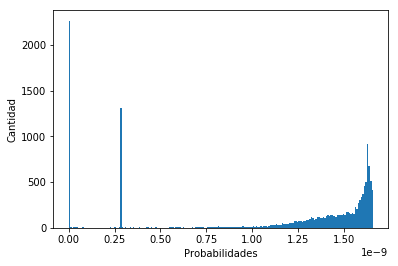

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

validation_probs = [prob(x) for x in validation[relevant_features].values]
plt.hist(validation_probs,bins=200)
plt.xlabel('Probabilidades')
plt.ylabel('Cantidad')
plt.show()

#### <font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i>  Ejercicio 10</font>  

En vista del histograma anterior, asignar un valor a la variable `epsilon` y crear un vector denominado `preds_val` con las predicciones para cada elemento del conjunto de validación. Este vector puede tomar los valores 0, para tráfico normal, y 1, para anomalía. Ajustar el valor de epsilon para maximizar el f1 score (podéis hacerlo manualmente). 


<div class="alert alert-block alert-info">
<i class="fa fa-info-circle" aria-hidden="true"></i> Para determinar el valor de la predicción para un caso, se ha de comparar la probabilidad almacenada en `validation_probs` con el valor de `epsilon` (si es menor, se trata de una anomalía, y se asigna el valor uno). 
</div>

In [30]:
from sklearn import metrics  

epsilon = 0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001
preds_val = list(map(lambda p: 1 if p<epsilon else 0, validation_probs))

print("precision: ", metrics.precision_score(validation_traffic, preds_val))  
print("recall: ", metrics.recall_score(validation_traffic, preds_val))
print("f1: ", metrics.f1_score(validation_traffic, preds_val))

precision:  0.999546485261
recall:  0.915662650602
f1:  0.955767562879


#### <font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i>  Ejercicio 11</font>  

Finalmente, reportar el resultado con respecto a los datos de test, almacenados en las variables `test` y `test_traffic`.

In [31]:
test_probs = [prob(x) for x in test[relevant_features].values]
preds_test = list(map(lambda p: 1 if p<epsilon else 0, test_probs))

print("precision: ", metrics.precision_score(test_traffic, preds_test))  
print("recall: ", metrics.recall_score(test_traffic, preds_test))
print("f1: ", metrics.f1_score(test_traffic, preds_test))  

precision:  0.990797546012
recall:  0.811557788945
f1:  0.89226519337


### 2.2 Modelo multivariado

En el modelo multivariado, la distribución de probabilidad se representa mediante el vector de medias, $\mu$ y la matriz de covarianzas, $\Sigma$, como:

$$
p(x) = \frac{1}{(2\pi)^\frac{n}{2} |\Sigma|^\frac{1}{2}}e^{\left(-\frac{1}{2}(x - \mu)^T\Sigma^{-1}(x-\mu)  \right) }
$$

Dada la distribución normal multivariada definida a partir de un vector de medias y la matriz de covarianzas, la clase `scipy.stats.multivariate_normal` permite calcular la probabilidad asociada a cada caso. 

La siguiente celda estima la función de densidad y calcula la probabilidad asociada a cada uno de los casos del conjunto de validación. 

In [32]:
from scipy.stats import multivariate_normal

means = train[relevant_features].mean().values
covs = np.cov(train[relevant_features].values.T)

validation_probs = multivariate_normal.pdf(validation[relevant_features].values, means, covs)

#### <font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i>  Ejercicio 12</font>  
Dibujar un histograma (200 bins) con estas probabilidades.

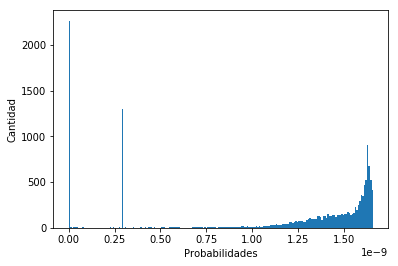

In [33]:
plt.hist(validation_probs,bins=200)
plt.xlabel('Probabilidades')
plt.ylabel('Cantidad')
plt.show()

#### <font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i>  Ejercicio 13</font>  

Proceder de manera similar al ejercicio 10. Predecir las etiquetas para los casos del conjunto de validación, y ajustar el valor de $\epsilon$ que maximice el f1 score.

In [37]:
epsilon = 0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001
preds_val = list(map(lambda p: 1 if p<epsilon else 0, validation_probs))

print("precision: ", metrics.precision_score(validation_traffic, preds_val))  
print("recall: ", metrics.recall_score(validation_traffic, preds_val))
print("f1: ", metrics.f1_score(validation_traffic, preds_val))  

precision:  0.999546485261
recall:  0.915662650602
f1:  0.955767562879


#### <font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i>  Ejercicio 14</font>  

Evaluar el modelo anterior (distribución y $\epsilon$) sobre los datos de test.

In [38]:
test_probs = multivariate_normal.pdf(test[relevant_features].values, means, covs)
preds_test = list(map(lambda p: 1 if p<epsilon else 0, test_probs))

print("precision: ", metrics.precision_score(test_traffic, preds_test))  
print("recall: ", metrics.recall_score(test_traffic, preds_test))
print("f1: ", metrics.f1_score(test_traffic, preds_test))  

precision:  0.990797546012
recall:  0.811557788945
f1:  0.89226519337


## 3. OneClassSVM

Por último, se va a evaluar uno de los modelos que implementa sklearn. En concreto, `OneClassSVM`, que es un algoritmo de tipo SVM en el que se acota el espacio en el que se encuentran los casos de entrenamiento. 

#### <font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i>  Ejercicio 15</font>  

Entrenar un modelo `svm.OneClassSVM` con los datos de entrenamiento. Fijar el parámetro `nu=prop_anomalies`.

In [60]:
from sklearn import svm

model = svm.OneClassSVM(nu=prop_anomalies, kernel="rbf")

#### <font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i>  Ejercicio 16</font>  

Utilizar el modelo anterior en la predicción del conjunto de validación. Almacenar los resultados en la variable `preds_val`. Para utilizar de manera correcta las métricas, sustituir el valor 1 por 0, y el valor -1 por 1. 

In [61]:
model.fit(train[relevant_features])
preds_val = list(map(lambda x: 0 if x == 1 else 1, model.predict(validation[relevant_features])))

In [62]:
print("precision: ", metrics.precision_score(validation_traffic, preds_val))  
print("recall: ", metrics.recall_score(validation_traffic, preds_val))
print("f1: ", metrics.f1_score(validation_traffic, preds_val))  

precision:  0.200380814217
recall:  0.918155380141
f1:  0.328966954451


#### <font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i>  Ejercicio 17</font>

Obtener los datos para el conjunto test. 

In [48]:
preds_test = list(map(lambda x: 0 if x == 1 else 1, model.predict(test[relevant_features])))

In [49]:
print("precision: ", metrics.precision_score(test_traffic, preds_test))  
print("recall: ", metrics.recall_score(test_traffic, preds_test))
print("f1: ", metrics.f1_score(test_traffic, preds_test))  

precision:  0.0455696915109
recall:  0.813567839196
f1:  0.0863052401514


<div style="text-align: right"> <font size=5> [<i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#990003">](#principio)</i></font></div>

---

<div style="text-align: right"> <font size=6><i class="fa fa-coffee" aria-hidden="true" style="color:#990003"></i> </font></div>